# Predicting Pop Popularity

This notebook will focus on trying to predict the percentage of pop songs in Billboard top 100. Initially, we will use traditional ARIMA methods. We will follow them up with multivariate machine learning based techniques.

---

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Basics
import pandas as pd
import numpy as np
import re

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Feature work
from sklearn.feature_extraction.text import CountVectorizer

# PreProcessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline, Pipeline

#Scoring
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# Imports and EDA

Lets bring in the data and merge our sets. We will lose some data, but given the sample size, it won't be critical.

In [4]:
filepath = 'data/'
charts = pd.read_csv(filepath+'new/hot_stuff_2.csv')

In [4]:
charts.head()

,url,weekid,week_position,song,performer,songid,instance,previous_week_position,peak_position,weeks_on_chart
0,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,http://www.billboard.com/charts/hot-100/1995-1...,1995-12-02,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,http://www.billboard.com/charts/hot-100/1997-1...,1997-10-11,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,http://www.billboard.com/charts/hot-100/2006-0...,2006-07-01,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,http://www.billboard.com/charts/hot-100/2009-1...,2009-10-24,1,3,Britney Spears,3Britney Spears,1,NaN,1,1


In [5]:
charts.shape

(320495, 10)

In [5]:
filepath = 'data/'
audio = pd.read_csv(filepath+'new/audiio.csv')

In [7]:
audio.head()

,songid,performer,song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),False,270740.0,91.0,...,10.0,-4.803,False,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,False,215733.0,88.0,...,7.0,-6.362,True,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,True,196760.0,86.0,...,6.0,-4.169,True,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,True,228185.0,61.0,...,8.0,-5.725,False,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In [6]:
df = pd.merge(charts, audio,
             on='songid',
             how='left',
             suffixes=('', '_y'))

In [7]:
del charts, audio

In [8]:
cols_to_drop = [col for col in list(df.columns) if '_y' in col]+['spotify_track_preview_url', 
                                                                 'url', 'spotify_track_id',
                                                                 'spotify_track_album', 'spotify_track_explicit']
df.drop(cols_to_drop, axis = 1, inplace = True)

In [9]:
df.isnull().sum()

weekid                           0
week_position                    0
song                             0
performer                        0
songid                           0
instance                         0
previous_week_position       30991
peak_position                    0
weeks_on_chart                   0
spotify_genre                13324
spotify_track_duration_ms    42191
spotify_track_popularity     42191
danceability                 42749
energy                       42749
key                          42749
loudness                     42749
mode                         42749
speechiness                  42749
acousticness                 42749
instrumentalness             42749
liveness                     42749
valence                      42749
tempo                        42749
time_signature               42749
dtype: int64

In [11]:
print('If we drop these rows, we will lose {}% of our data.'.format(round(df.isnull().sum().max()/df.shape[0]*100,2)))

If we drop these rows, we will lose 13.24% of our data.


In [9]:
df.dropna(inplace = True)

In [9]:
(df[df['weeks_on_chart']>60][['songid','weeks_on_chart']])\
             .drop_duplicates(subset='songid', keep='last')\
             .sort_values('weeks_on_chart')



,songid,weeks_on_chart
21544,DemonsImagine Dragons,61
138190,You And MeLifehouse,62
315935,Ho HeyThe Lumineers,62
79257,Before He CheatsCarrie Underwood,64
20523,Rolling In The DeepAdele,65
20532,Party Rock AnthemLMFAO Featuring Lauren Bennet...,68
79261,Counting StarsOneRepublic,68
315952,How Do I LiveLeAnn Rimes,69
315959,I'm YoursJason Mraz,76
20554,SailAWOLNATION,79


# Engineering some new Features

### Genre

In [10]:
def merge_words(gen_list):
    gen_list_new = []
    for i in gen_list:
        gen_list_new.append(i.replace(' ',''))
    return gen_list_new

In [11]:
df['spotify_genre'] = df['spotify_genre'].apply(lambda x: re.sub(r'[\[\]]','',x))\
                                         .apply(lambda x: x.split(','))\
                                         .apply(lambda x: merge_words(x))\
                                         .apply(lambda x: ' '.join(x))
                                            

In [12]:
vectoriser = CountVectorizer()
sparse_genres = vectoriser.fit_transform(df['spotify_genre'])

genres_df = pd.DataFrame(sparse_genres.todense(), columns=vectoriser.get_feature_names())

In [13]:
drop_genre_cols = (genres_df.sum()>15000)
drop_genre_cols = [x for x, y in zip(list(drop_genre_cols.index), list(drop_genre_cols.values)) if y == False]

In [14]:
genres_df.drop(drop_genre_cols, axis=1, inplace=True)

In [15]:
genres_df['other'] = genres_df.apply(lambda x: 1 if x.sum()==0 else 0, axis = 1)

In [16]:
df = pd.concat([df.drop('spotify_genre', axis = 1).reset_index(drop = True), genres_df], axis = 1)

In [18]:
genres_df.sum().sort_values().tail(10)

albumrock         25644
poprap            28717
adultstandards    28900
post              29788
pop               39831
softrock          40400
mellowgold        40787
dancepop          41565
other             44045
rock              47276
dtype: int64

---

# Time Series Modelling

Time series problems contain many challenges and questions to ask. As referenced in Deep Learning for Time Series by Jason Brownlee, there are 7 major considerations that we will look at:
- **Endogenous vs. Exogenous:** which variables are effected by those in the system (endo) which are outside/indirectly affected (exo)?
- **Unstructured vs. Structured:** seasonality or other features that render the time series strucured or structureless?
- **Regression vs. Classification:** are we looking for up/down or how much does it go up?
- **Univariate vs. Multivariate:** are we looking at a model that works with just autocorrelations or variables that impact a trend?
- **Single step vs. Multi step:** one step into the future or a long term prediction?
- **Static vs. Dynamic:** do we want to be able to update the model as we go along or is it fixed in time?
- **Contiguous vs. Discontiguous:** is the time series full (all data evenly spaced) or are there gaps?

### This section will look at various ways we can approach making predictions about the future or music.

There are many things we can look at with the data that we have.
1. Subset by genre (percentage of songs in the charts that are of a certain genre) and try to look at their trends to predict whether the genre will grow
2. Look at certain spotify features (underlying musical features) to see if there are trends in certain types of music in the charts
3. 

In [17]:
def convert_to_dt_indexed(df):
    return df.set_index(pd.to_datetime(df['weekid'])).drop('weekid', axis = 1)

In [18]:
time_df = convert_to_dt_indexed(df)

In [77]:
time_df.columns

Index(['week_position', 'song', 'performer', 'songid', 'instance',
       'previous_week_position', 'peak_position', 'weeks_on_chart',
       'spotify_track_duration_ms', 'spotify_track_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'adultstandards', 'albumrock', 'brillbuildingpop', 'bubblegumpop',
       'classicrock', 'contemporarycountry', 'country', 'countryroad',
       'dancepop', 'disco', 'folkrock', 'funk', 'hiphop', 'hippop',
       'mellowgold', 'motown', 'newwavepop', 'pop', 'poprap', 'poprock',
       'post', 'quietstorm', 'rap', 'rock', 'softrock', 'soul',
       'urbancontemporary', 'other'],
      dtype='object')

In [29]:
ncols = 3
nrows = 14
index_pos = []
for i in range(ncols):
    for j in range(nrows):
        index_pos.append([j,i])

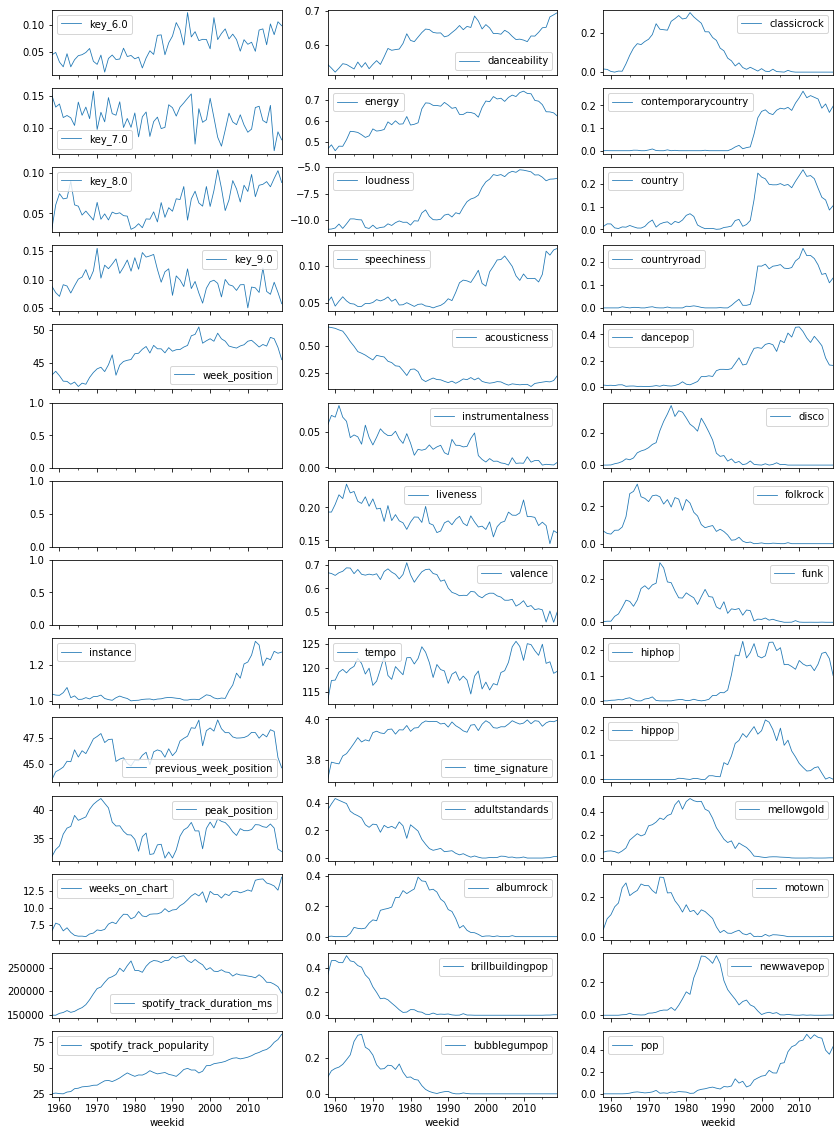

In [207]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14,20), sharex = True)
for i, v in enumerate(time_df.iloc[:,8:].columns):
    try:
        time_df[[v]].resample('y').mean().plot(ax = axs[tuple(index_pos[i])], lw=0.8);
    except:
        pass

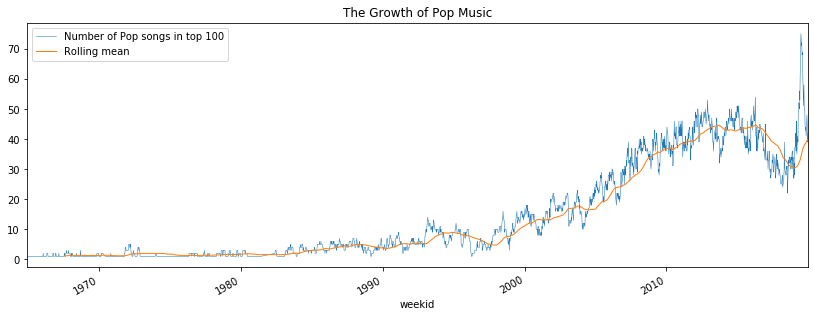

In [58]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['pop']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.5, ax=ax);
time_df[time_df['pop']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Pop songs in top 100', 'Rolling mean'])
ax.set_title('The Growth of Pop Music');


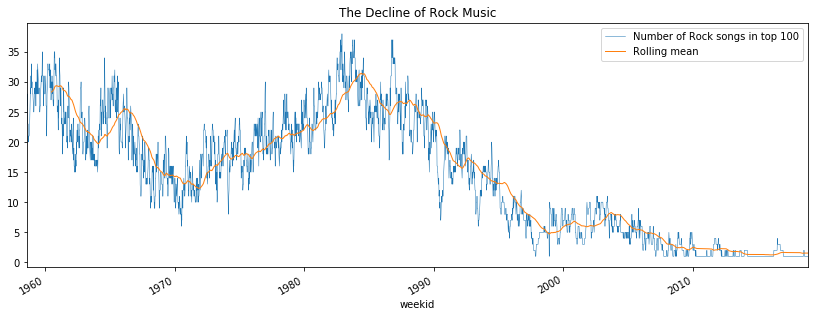

In [68]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['rock']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.5, ax=ax);
time_df[time_df['rock']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Rock songs in top 100', 'Rolling mean'])
ax.set_title('The Decline of Rock Music');


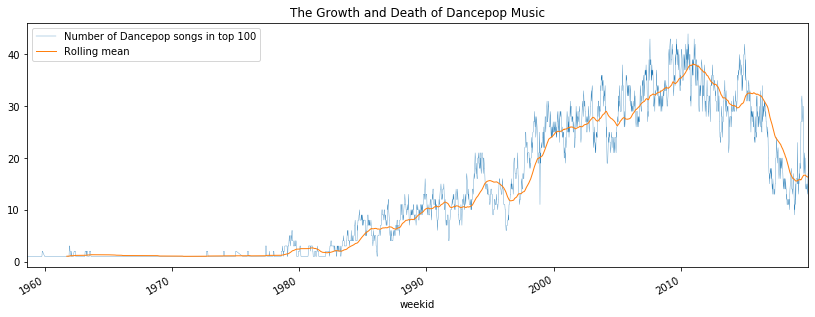

In [69]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['dancepop']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df[time_df['dancepop']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Dancepop songs in top 100', 'Rolling mean'])
ax.set_title('The Growth and Death of Dancepop Music');


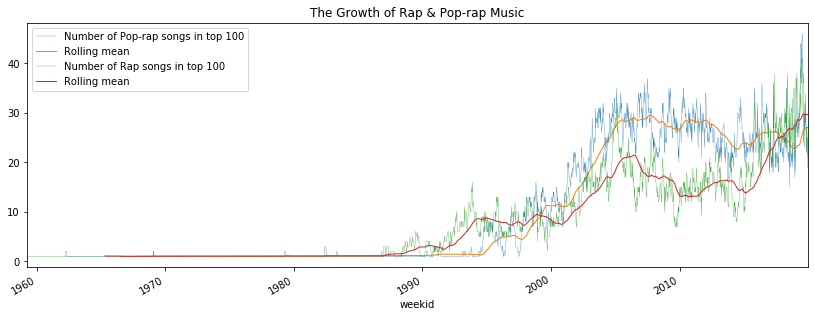

In [82]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['poprap']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df[time_df['poprap']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
time_df[time_df['rap']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df[time_df['rap']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Pop-rap songs in top 100', 'Rolling mean', 'Number of Rap songs in top 100', 'Rolling mean'])
ax.set_title('The Growth of Rap & Pop-rap Music');

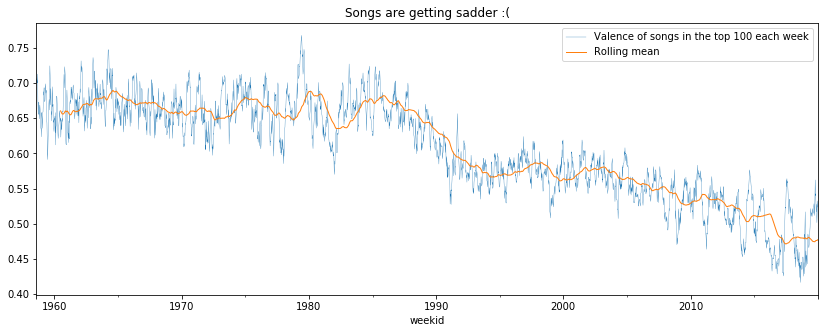

In [71]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['valence']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['valence']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Valence of songs in the top 100 each week', 'Rolling mean'])
ax.set_title('Songs are getting sadder :(');

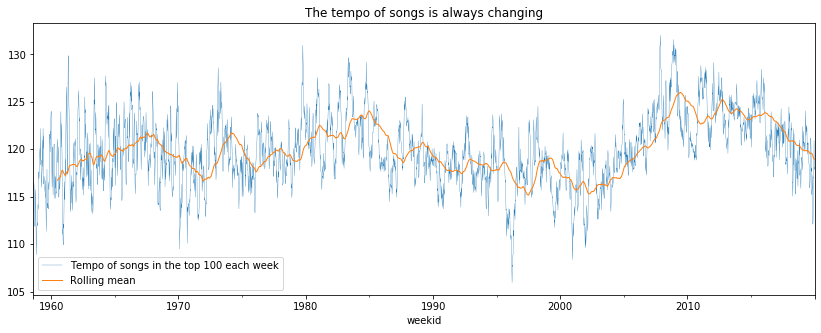

In [72]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['tempo']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['tempo']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Tempo of songs in the top 100 each week', 'Rolling mean'])
ax.set_title('The tempo of songs is always changing');

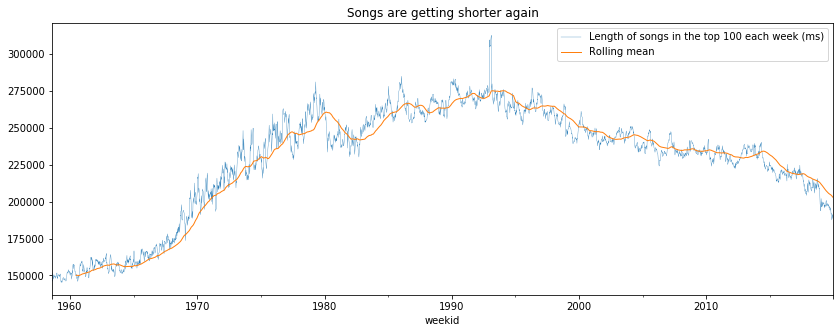

In [80]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['spotify_track_duration_ms']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['spotify_track_duration_ms']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Length of songs in the top 100 each week (ms)', 'Rolling mean'])
ax.set_title('Songs are getting shorter again');

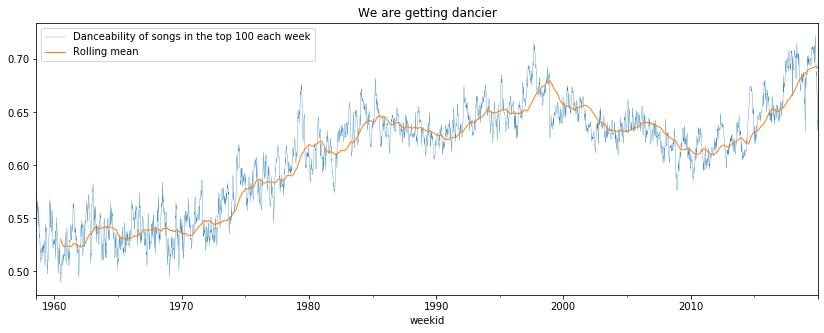

In [84]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['danceability']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['danceability']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Danceability of songs in the top 100 each week', 'Rolling mean'])
ax.set_title('We are getting dancier');

# Forecasting

There are many models we can look at.
Some options:
- Observing the movement of the top song on billboard given some features.
- Percentage of a given genre in top 100

In [30]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [19]:
time_df['key'] = time_df['key'].astype(str)
time_df = pd.concat([(pd.get_dummies(time_df[['mode', 'key']], drop_first=True)),
                     time_df.drop(['mode', 'key'], axis=1)],
                    axis=1)


### Model 1: Predicting pop with autocorrelations

Our aim in this section will be to use previous pop data to forecast future pop success. We will look for a multistep forecast so that we can predict multiple time units (weeks) into the future.

Here we will try to predict specifically the next 8 weeks.

We'll start by extracting just pop from our dataframe and plotting it.

In [20]:
pop_trends = time_df[['pop']].groupby('weekid').mean()

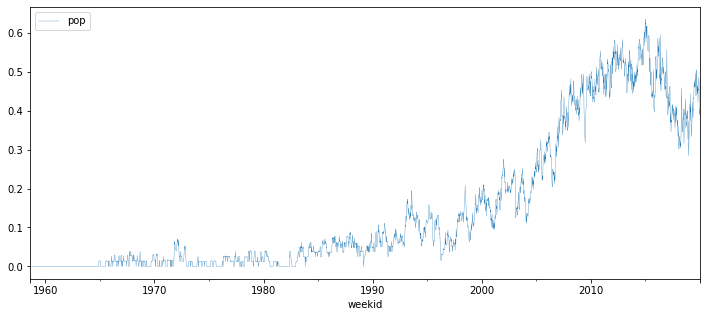

In [94]:
fig, ax = plt.subplots(figsize=(12,5))
pop_trends.plot(lw=0.3, ax=ax);

The above plot doesn't show stationarity (the mean and covariance shouldnt be a function of time) - we will need to subset the data to fulfil this criteria.

Historic data may not be super valuable so we will focus on more recent years.

In [21]:
year = 2015
pop_trends = pop_trends[pop_trends.index>'{}-01-01'.format(year)]

And lets look at each year seperately in our new subsetted data.

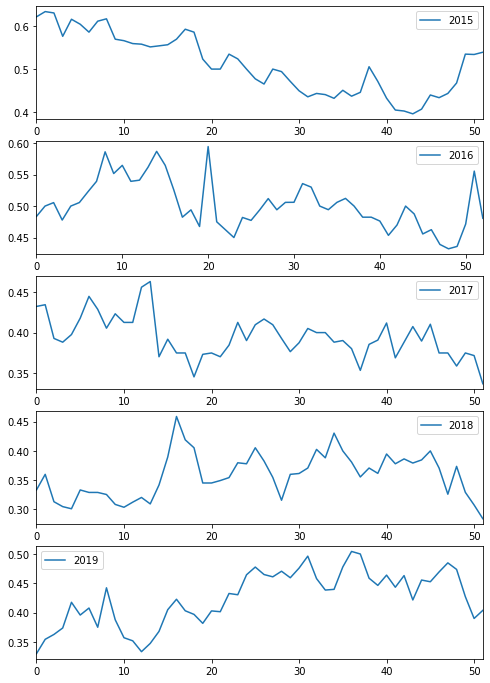

In [251]:
years = list(pop_trends.index.year.unique())
fig, ax = plt.subplots(figsize=(8,12), nrows=len(years))
for i,y in enumerate(years):
    temp_pop_df = pop_trends[pop_trends.index.year==y]
    temp_length = temp_pop_df.shape[0]
    temp_pop_df.index = [i for i in range(temp_length)]
    temp_pop_df.columns = [y]
    temp_pop_df.plot(ax=ax[i])
    
plt.show()

At first glance, there doesn't appear to be much seasonality in pop listening. Lets look in a bit more detail..

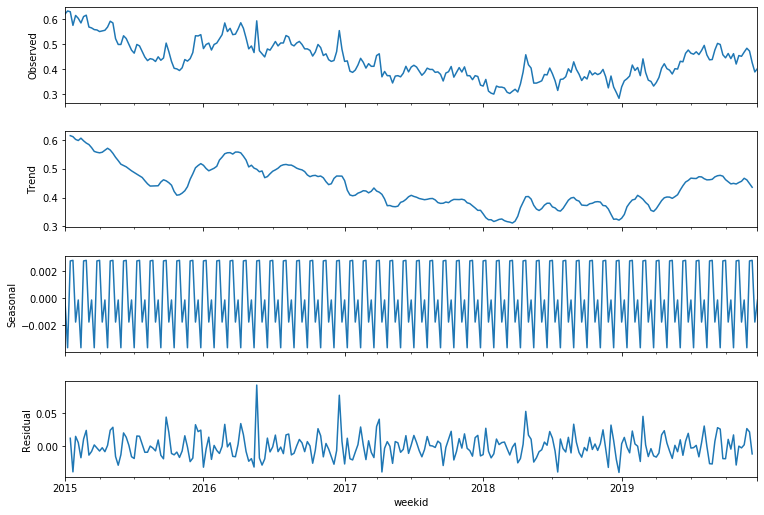

In [252]:
period = len(years)
decomposition = seasonal_decompose(pop_trends, freq=period)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

We shouldn't really expect any repeating trend for the number of pop songs in the top 100. It may be the case that at Christmas time there are a more pop songs in the charts but even that looks spurious.

### Baseline/Naive Models

Given what we've explored above (no seasonality or repeating trends), we would expect that our most sensible estimate for future observations would be based on the most recent data. Tomorrow will most likely be the same as yesterday (as opposed to using the same week last year/month etc.)

In [35]:
from math import sqrt
from numpy import array, split, median, mean
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import mean_squared_error

We are trying to look 4 weeks forward, so we will split our data accordingly into batches of 4.

Lets first look at our weekly data by year.

In [22]:
years = list(pop_trends.index.year.unique())
for i,y in enumerate(years):
    length = pop_trends[pop_trends.index.year==y].shape[0]
    first_entry = str(pop_trends[pop_trends.index.year==y].index[0]).split(' ')[0]
    print('Year {} has {} entries and starts on {}.'.format(y, length, first_entry))

Year 2015 has 52 entries and starts on 2015-01-03.
Year 2016 has 53 entries and starts on 2016-01-02.
Year 2017 has 52 entries and starts on 2017-01-07.
Year 2018 has 52 entries and starts on 2018-01-06.
Year 2019 has 52 entries and starts on 2019-01-05.


It's not best practice but we will remove the first week of data from 2016 to equalise observations per year.

In [23]:
trimmed_pop_trends = pop_trends[pop_trends.index!='2016-01-02']

In [6]:
def split_dataset(data, test_split, periods):
    n_test = int(len(data)*test_split)
    train, test = data[:-n_test], data[-n_test:] 
    train = array(split(train, len(train)/periods))
    test = array(split(test, len(test)/periods))
    return train, test

In [7]:
def evaluate_forecasts(actual, predicted):
    
    scores = []
    s=0
    
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
        
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
            
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [8]:
def evaluate_model(model_func, train, test):
    
    history = [x for x in train]
    predictions = []
    
    for i in range(len(test)):
        yhat_sequence = model_func(history)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
        
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    
    return score, scores

In [9]:
def weekly_persistence(history):
    first_four_weeks = history[-1]
    value = first_four_weeks[-1, 0]
    forecast = [value for _ in range(4)]
    return forecast

def monthly_persistence(history):
    first_four_weeks = history[-1]
    return first_four_weeks[:, 0]

def month_one_year_ago(history):
    last_year = history[-13]
    return last_year[:, 0]

In [11]:
year = 2015
data = trimmed_pop_trends[trimmed_pop_trends.index>'{}-01-01'.format(year)]
train, test = split_dataset(data.values, 0.2, 4)

RMSE for weekly: 0.041
RMSE for monthly: 0.046
RMSE for one_year_ago: 0.08


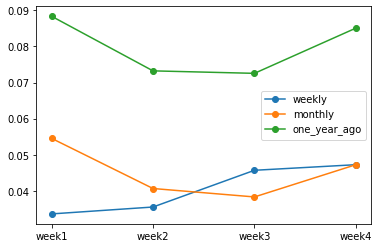

In [43]:
models = {}
models['weekly'] = weekly_persistence
models['monthly'] = monthly_persistence
models['one_year_ago'] = month_one_year_ago

weeks = ['week{}'.format(week) for week in range(1,5)]
for name, func in models.items():
    score, scores = evaluate_model(func, train, test)
    plt.plot(weeks, scores, marker='o', label=name)
    print('RMSE for {}: {}'.format(name, round(score,3)))
    
plt.legend()
plt.show()

Our best prediction is to use the most recent week as our prediction. This follows our prior hypothesis that the most recent date is best.

We see that we minimise error by selecting the most recent week's data. This delivers us an average miss of 4% of the pop songs in the charts.

## Classic Linear Methods

We will start with a more simplified model that uses univariate (just considering autocorrelations), multistep modelling with classic linear methods.

We will use walk-forward validation wherein we predict week 2 on week 1, week 3 on weeks 1 and 2, week 4 on weeks 1,2 and 3 etc.

## ARIMA models

In [44]:
# Please note that this function is an adaptation from blackarbs.com - credit to them!
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

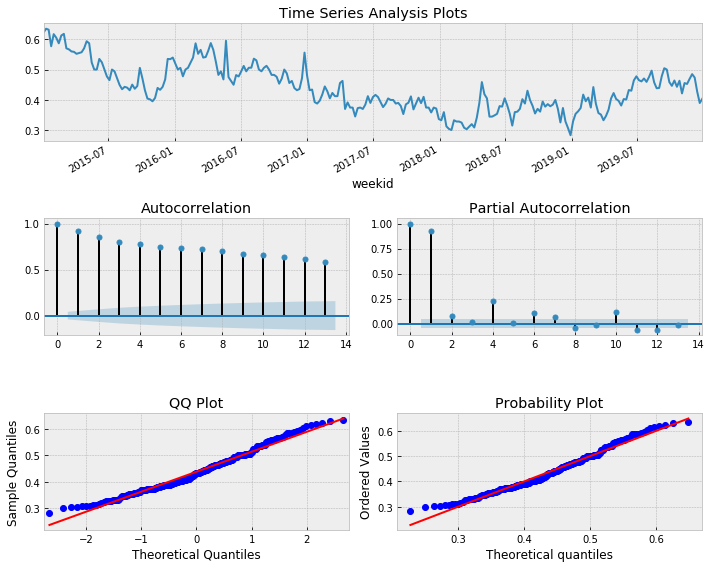

In [45]:
tsplot(trimmed_pop_trends['pop'], lags=13)

We can see that our data is non stationary. Our autocorrelation plot shows a gradual decrease where we would want to see a sharp drop-off after the first or second lag.

We can use differencing to eliminate this effect. Here we simply minus each point by the one previous to it.

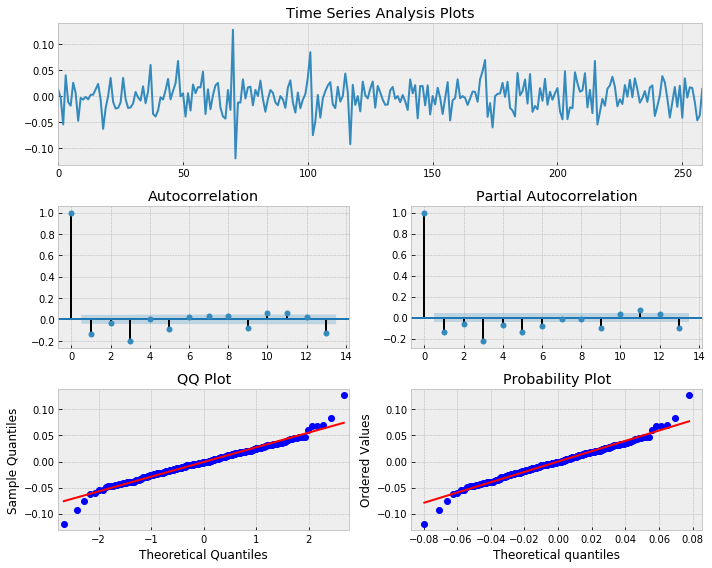

In [293]:
tsplot(np.diff(trimmed_pop_trends['pop'], n=1), lags=13)

We see better autocorrelations here but still some concern. Also the edge values in the QQ plots suggest there are still some serial correlations - this may be down to the values at lags 1,3,5,9 and 13.

We will search through different values of p, d and q to identify the optimal difference value and autoregressive and moving average coeffs. The autoregressive feature will allow us to handle momentum and the moving average will handle sudden spikes.

order: (1, 0, 3)


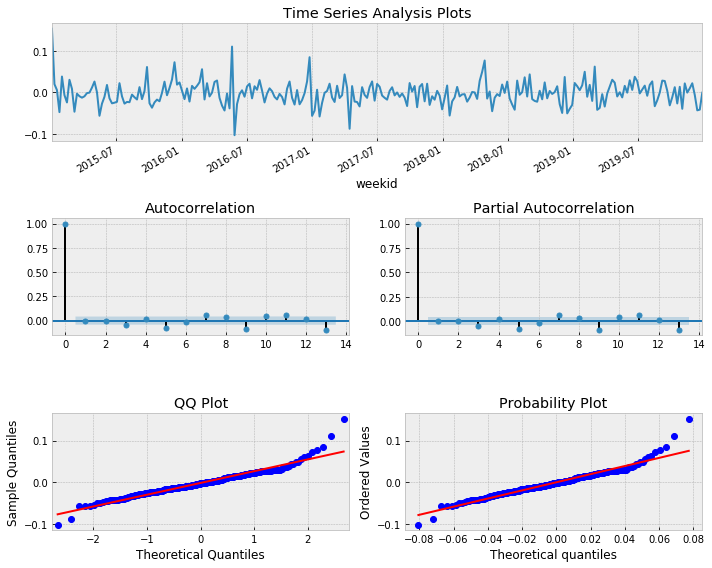

In [48]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5)
d_rng = range(2) 
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(trimmed_pop_trends['pop'], order=(i,d,j)).fit(method='mle', trend='c')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('order: {}'.format(best_order))

tsplot(best_mdl.resid, lags=13)

Our ACF and PACF plots show only minor deviations. These probably link to the edge values in the QQ plot.

We will now create our model as before but with (1,0,3) ARIMA.

In [49]:
def to_series(data):
    series = [week[:, 0] for week in data]
    series = array(series).flatten()
    return series

def arima_forecast(history):
    series = to_series(history)
    model = smt.ARIMA(series, order=(1,0,3))
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(series), len(series)+4)
    return yhat

def ses_forecast(history):
    series = to_series(history)
    model = smt.SimpleExpSmoothing(series)
    model_fit = model.fit()
    yhat = model_fit.predict(len(series), len(series)+4)
    return yhat

RMSE for ARIMA: 0.034
RMSE for SES: 0.039


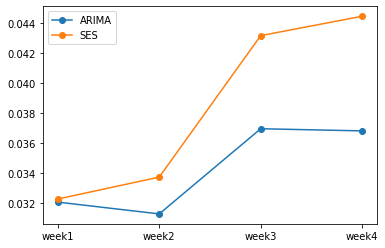

In [50]:
models = {}
models['ARIMA'] = arima_forecast
models['SES'] = ses_forecast

weeks = ['week{}'.format(week) for week in range(1,5)]
for name, func in models.items():
    score, scores = evaluate_model(func, train, test)
    plt.plot(weeks, scores, marker='o', label=name)
    print('RMSE for {}: {}'.format(name, round(score,3)))
    
plt.legend()
plt.show()

Here we have improved our RMSE from our baseline 0.041 to 0.034 by using ARIMA.

In [51]:
model = smt.ARIMA(data['pop'], order=(1,0,3))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(data['pop']), len(data['pop'])+4)

In [52]:
import datetime
def create_forecast_plot_data(data, prediction):
    
    new_data = data.copy()
    prediction_index = pd.DatetimeIndex(data=[datetime.date(2020, 1, 4),
                                              datetime.date(2020, 1, 11),
                                              datetime.date(2020, 1, 18),
                                              datetime.date(2020, 1, 25),
                                              datetime.date(2020, 2, 1)])

    prediction = pd.DataFrame(prediction, columns=['pop'], index=prediction_index)
    merged = pd.merge(prediction, new_data, how='outer', on='pop')
    merged.index = new_data[0:5].index.append(new_data.index+datetime.timedelta(weeks=5))
    
    merged['hue'] = None
    merged.loc[merged.index>='2020-01-04','hue'] = 'Data'
    merged.loc[merged.index<'2020-01-04','hue'] = 'Forecast'
    
    return merged


In [53]:
df_plot = create_forecast_plot_data(data, yhat.values)

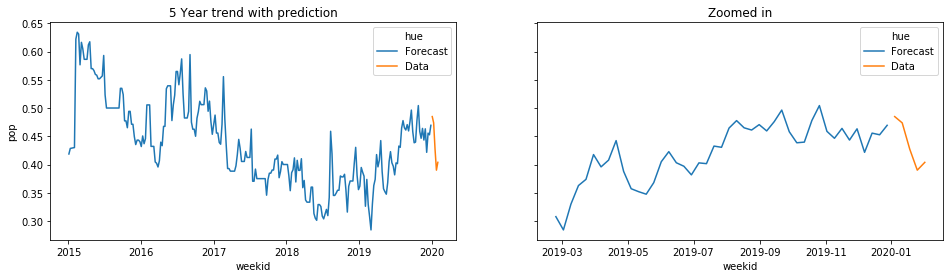

In [54]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4), sharey=True)
sns.lineplot(x=df_plot.index, y=df_plot['pop'], hue=df_plot['hue'], ax=ax[0]);
sns.lineplot(x=df_plot.tail(50).index, y=df_plot.tail(50)['pop'], hue=df_plot.tail(50)['hue'], ax=ax[1]);
ax[0].set_title('5 Year trend with prediction');
ax[1].set_title('Zoomed in');

## Machine Learning

Typically the classical methods perform better for multistep univariate models but when we start to introduce complexity (additional variables), more advanced methods start to offer us a real benefit.

This section will focus on the introduction of extra data to enrich our model. We will continue to predict 4 time steps ahead but now we will move to multivariate modelling.

### Predicting with other genres

In [23]:
genres = ['adultstandards', 'albumrock', 'brillbuildingpop', 'bubblegumpop', 'classicrock', 
          'contemporarycountry', 'country', 'countryroad', 'dancepop', 'disco', 'folkrock', 'funk', 
          'hiphop', 'hippop', 'mellowgold', 'motown', 'newwavepop', 'pop', 'poprap', 'poprock',
          'post', 'quietstorm', 'rap', 'rock', 'softrock', 'soul', 'urbancontemporary']

In [26]:
genres_df = time_df[time_df.index>'{}-01-01'.format(year)][genres].groupby('weekid').mean()

In [30]:
genres_df.to_csv('multivar_data.csv')

Change kernel to tensorflow.

In [1]:
from math import sqrt
from numpy import split, array
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

In [183]:
genres_df = pd.read_csv('multivar_data.csv',
                            header=0,
                            infer_datetime_format=True,
                            parse_dates=['weekid'],
                            index_col=['weekid'])

Lets introduce rap into our model.

In [193]:
genres = ['pop', 'rap']

In [194]:
genres_df = genres_df[genres]

In [195]:
genres_trends = genres_df[genres_df.index!='2016-01-02']
year = 2015
data = genres_trends[genres_trends.index>'{}-01-01'.format(year)]
train, test = split_dataset(data.values, 0.2, 4)

In [196]:
def to_supervised(train, n_input, n_out=4):
    
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = [], []
    in_start = 0
    
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out

        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return array(X), array(y)

In [197]:
def build_model(train, n_input):
    
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] 
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model


In [198]:
def forecast(model, history, n_input):
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat


In [204]:
def evaluate_model(train, test, n_input):
    
    model = build_model(train, n_input)
    history = [x for x in train]
    predictions = []
    
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [205]:
n_input = len(genres)
runs = 10
lstm_results = []

for _ in range(runs):
    lstm_results.append(evaluate_model(train, test, n_input))

In [247]:
mean_score = np.mean([score[0] for score in lstm_results])
mean_results = list(map(np.mean, zip(*[i[1] for i in lstm_results])))

RMSE for Multivariate LSTM: 0.032


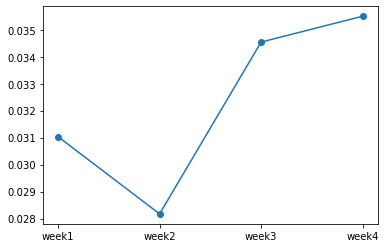

In [249]:
weeks = ['week{}'.format(week) for week in range(1,5)]
print('RMSE for Multivariate LSTM: {}'.format(round(mean_score,3)))
pyplot.plot(weeks, mean_results, marker='o', label='lstm') 
pyplot.show()

We provided an extra input to attempt to improve our forecast. We fed our LSTM network information for the percentage of rap as well as pop in the top charts each week.

It feels intuitive that you could predict pop percentages better if you know the percentages of other genres.

With our above model, we achieve a slightly better average RMSE than our univariate ARIMA model.

The improvement is only modest for the slight increase in model complexity.

---